In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


/kaggle/input
/kaggle/input/membrane-segment-u-net
/kaggle/input/membrane-segment-u-net/Task4 Dataset
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/train
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/train/label
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/train/aug
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/train/image


In [12]:
train_img = '/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/train/image'
train_labels = '/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/train/label'
test_img = '/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test'

In [13]:
import cv2

input_list = []
output_list = []

for dirname, _, filenames in os.walk(train_img):
    for filename in filenames:
#         print(filename)
        train_file_img = os.path.join(dirname, filename)
        train_label_img = os.path.join(train_labels,filename)
                
        image = cv2.imread(train_file_img,0)
        image = cv2.resize(image, (256, 256))
        
        image_features = image.astype('float32') / 255.0        
        input_list.append(image_features)
        
        image = cv2.imread(train_label_img,0)
        image = cv2.resize(image, (256, 256))
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image_features = image.astype('float32') / 255.0        
        output_list.append(image_features)
        
input_list = np.expand_dims(input_list, axis=-1)
output_list = np.expand_dims(output_list, axis=-1)

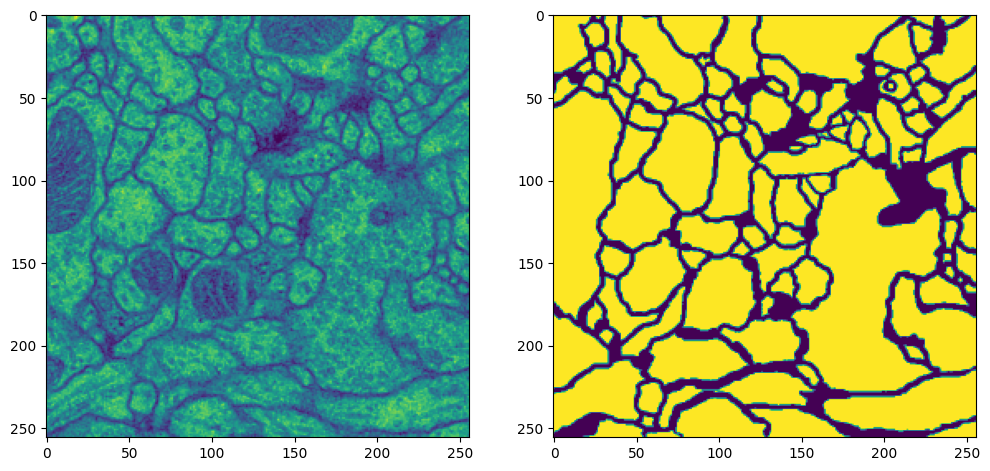

(24, 256, 256, 1)


In [14]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

images = input_list
masks = output_list
images = np.array(images)
masks = np.array(masks)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.2, random_state = 42)

import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow((y_train[image_number]))
plt.show()

print(X_train.shape)

In [15]:
import tensorflow as tf

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)   # 256 x 256
    s2, p2 = encoder_block(p1, 128)     # 128 x 128
    s3, p3 = encoder_block(p2, 256)     # 64 x 64
     # 32 x 32

    # Bridge
    b1 = conv_block(p3, 1024)           # 16 x 16

    # Decoder
#     d1 = decoder_block(b1, s4, 512)     # 32 x 32
    d2 = decoder_block(b1, s3, 256)     # 64 x 64
    d3 = decoder_block(d2, s2, 128)     # 128 x 128
    d4 = decoder_block(d3, s1, 64)      # 256 x 256

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="UNET")
    return model

input_shape = (256, 256, 1)
model = build_unet(input_shape)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     36,928 │ leaky_re_lu_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ leaky_re_lu_15[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ leaky_re_lu_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ leaky_re_lu_17[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_19[0][0] 

 Total params: 16,494,401 (62.92 MB)

 Trainable params: 16,486,721 (62.89 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [20]:
seed=24
batch_size = 10
# from keras.preprocessing.image import ImageDataGenerator|
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

# x = image_generator.next()
# y = mask_generator.next()
# for i in range(0,1):
#     image = x[i]
#     mask = y[i]
#     plt.subplot(1,2,1)
#     plt.imshow(image[:,:,0], cmap='gray')
#     plt.subplot(1,2,2)
#     plt.imshow(mask[:,:,0])
#     plt.show()

# steps_per_epoch = 3*(len(X_train))//batch_size
steps_per_epoch = 5
history = model.fit(my_generator, steps_per_epoch=steps_per_epoch, epochs=10,validation_data=validation_datagen, validation_steps=2 )

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.9041 - loss: 0.2263 - val_accuracy: 0.1130 - val_loss: 19.8579
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9069 - loss: 0.2171 - val_accuracy: 0.1214 - val_loss: 11.1437
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9055 - loss: 0.2154 - val_accuracy: 0.1969 - val_loss: 3.2736
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9083 - loss: 0.2088 - val_accuracy: 0.8317 - val_loss: 0.4397
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9068 - loss: 0.2096 - val_accuracy: 0.9015 - val_loss: 0.3081
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9089 - loss: 0.2053 - val_accuracy: 0.9045 - val_loss: 0.2957
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9086 - loss: 0.2025 - val_accuracy: 0.9049 - val_loss: 0.2895
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9077 - loss: 0.2022 - val_accuracy: 0.9015 - val_loss: 0.2929
Epoch 9/10
5/

In [ ]:
# import matplotlib.pyplot as plt
# # print(type(output_list))
# output_list = np.array(output_list)
# # print(type(output_list))
# input_list = np.array(input_list)
# input_list.shape

# plt.imshow(input_list[0])
# plt.show()

In [21]:
for dirname, _, filenames in os.walk('/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test'):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/21_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/27_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/6_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/11.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/28_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/7_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/4.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/9.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/23_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/10_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/3_predict.png
/kaggle/input/membrane-segment-u-net/Task4 Dataset/membrane/test/14.png
/kaggle/inpu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


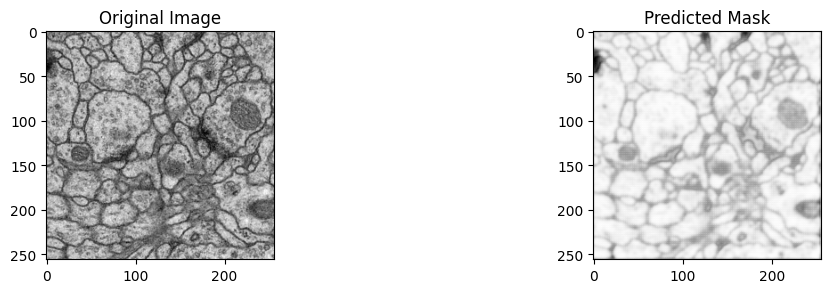

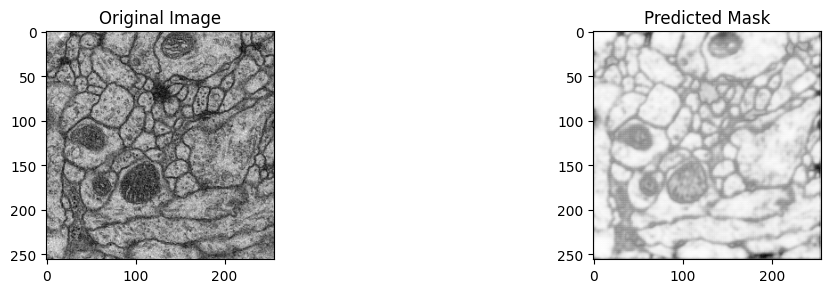

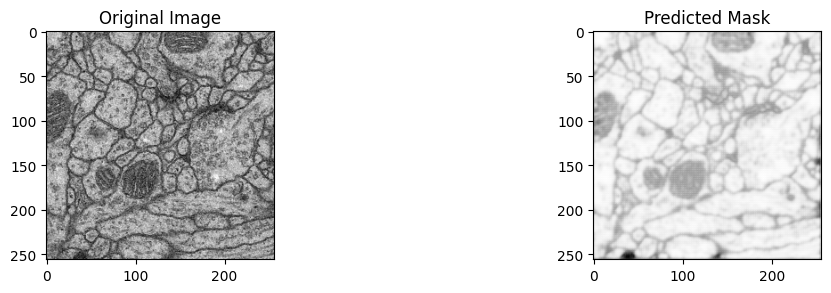

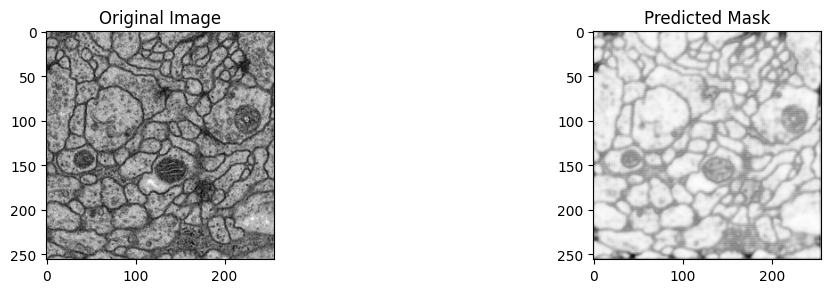

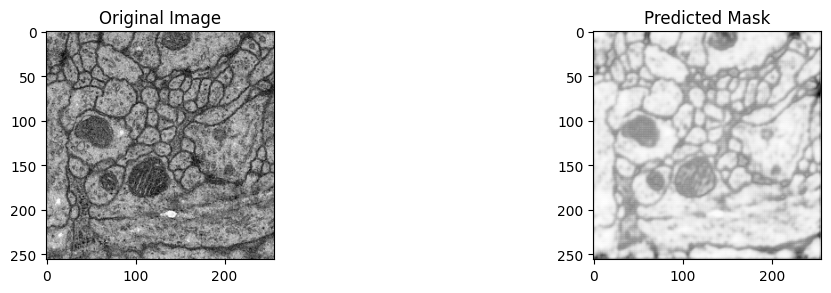

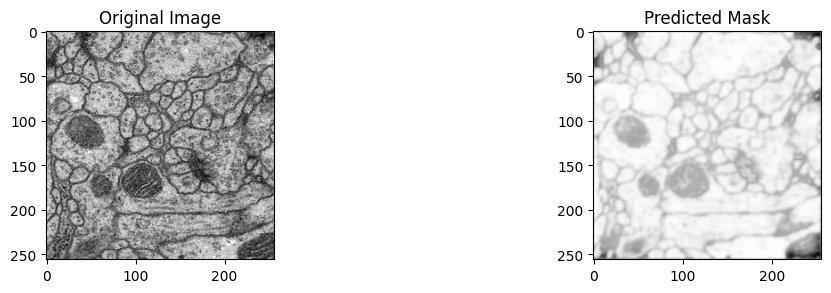

In [23]:
test_input = []

for dirname, _, filenames in os.walk(test_img):
    for filename in filenames:
#         print(filename)
        test_file_img = os.path.join(dirname, filename)
    
        image = cv2.imread(test_file_img,0)
        image = cv2.resize(image, (256, 256))
        
        image_features = image.astype('float32') / 255.0        
        test_input.append(image_features)
        
test_input = np.expand_dims(test_input, axis=-1)
Xtest = np.array(test_input)

predictions = model.predict(X_test, batch_size=16)

import matplotlib.pyplot as plt

for i in range(len(X_test)):
    plt.figure(figsize=(10, 5))
    
    # Display the original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    
    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    
    plt.show()
